# Audio Waves

In [1]:
# define the audio input
speech="audiolimpio.wav"

## 1) Processing Audio

In [2]:
import wave
import numpy as np

In [3]:
with wave.open(speech,'r') as spf: 
    sound_info = spf.readframes(-1)
    sound_info = np.frombuffer(sound_info, int)
    
    nframes = spf.getnframes() # number of frames
    frate = spf.getframerate() # frames per second

In [4]:
print(sound_info)

[  844450700197892  1407409243488264   844450700263430 ...
 -1688892810395657 -1407417833553931 -1125929971875849]


In [5]:
len(sound_info)

193974

In [6]:
print(frate) 
print(nframes)
length = nframes/float(frate)
print(length) # length

44100
775896
17.59401360544218


In [7]:
onesec_info = round(len(sound_info)/length)

## 2) Drawing Audio Wave

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

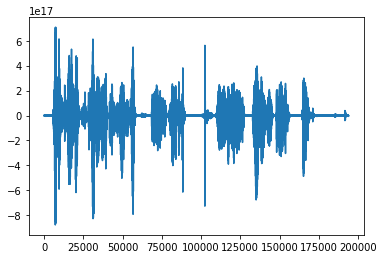

In [9]:
# Plot full soundwave
plt.plot(sound_info)

### 2.5) Drawing Audio Gif

In [10]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc

In [11]:
rc('animation', html='html5')

fig, ax = plt.subplots()
ylim = max(abs(sound_info)) * 1.1

mod = 10 # from 1 to length

def animate(i):
    ax.cla()
    ax.set_ylim(-ylim,ylim)
    ax.set_axis_off()
    
    current = (int(i * onesec_info/ mod),int((i + 1) * onesec_info / mod))
    ax.plot(sound_info[current[0]:current[1]],lw=0.1)
    

frames = int(length) * mod
ani = FuncAnimation(fig, animate, frames=frames, interval = 1000/mod, repeat=False)
plt.close()

In [12]:
ani

Note: when removing axis with set_axis_off(), the line width increases for some reason. I find it convenient to set it to lw = 0.1 in that case.

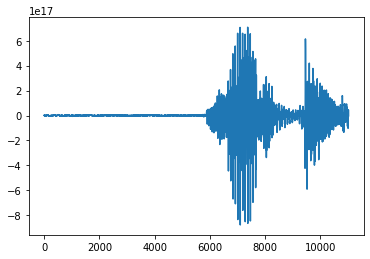

In [27]:
plt.plot(sound_info[0:onesec_info * 1]) # first second

## 3) Drawing spectrums

In [28]:
import spectrum

In [29]:
freq = spectrum.speriodogram(sound_info[:onesec_info]) # this is the frequency spectrum
print(freq)

[9.91607440e+35 6.38882298e+35 8.00210038e+33 ... 1.53627533e+33
 9.22180547e+33 1.81788627e+33]


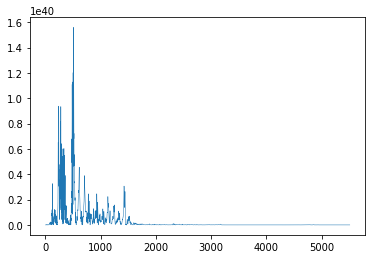

In [30]:
plt.plot(freq, lw=0.5)

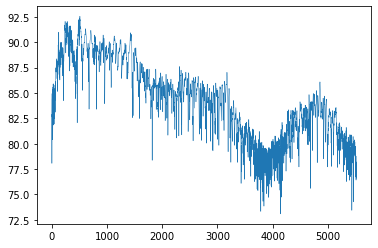

In [31]:
# this is the power spectrum, Log(freq)
#spectrum.Periodogram(sound_info[:onesec_info]).plot() 
plt.plot(np.log(freq), lw=0.5)
plt.grid(False)

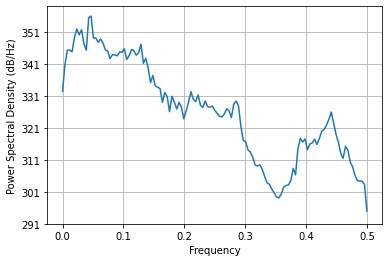

In [32]:
# no clue what this is, check https://pyspectrum.readthedocs.io/en/latest/ref_fourier.html#spectrum.periodogram.Periodogram
Welfreq = spectrum.WelchPeriodogram(sound_info[:onesec_info]) # this is the frequency spectrum
#Welfreq
#print(4*np.log(Welfreq[0][0]))

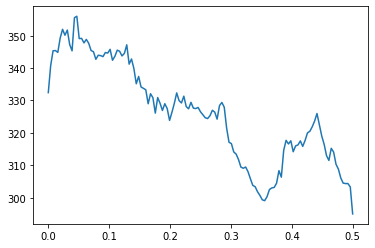

In [33]:
plt.plot(Welfreq[0][1],10*np.log10(Welfreq[0][0]))

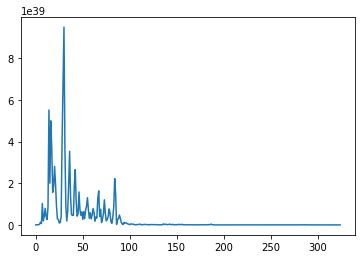

In [34]:
# This is a P-nearest-averaged spectrum. 
Danfreq = spectrum.DaniellPeriodogram(sound_info[:onesec_info],8) # this is the frequency spectrum
#print(Danfreq[0])
plt.plot(Danfreq[0])

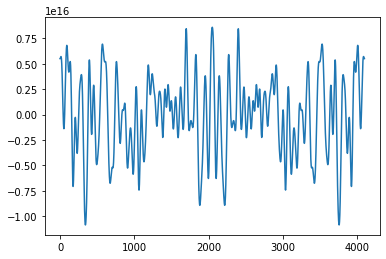

In [35]:
# no idea. A symmetric spiky wave, for all I know.
# higher lag = less spikes (lag=1 means Gauss bell). less length = less spikes, Less info?
CORRfreq = spectrum.CORRELOGRAMPSD(sound_info[:round(onesec_info/1)], lag=100)
#print(CORRfreq)
plt.plot(CORRfreq)

In [36]:
Foufreq = spectrum.FourierSpectrum(sound_info[:round(onesec_info/1)], lag=32, sampling=1024, NFFT=512)
#print(Foufreq[0])
#plt.plot(Foufreq)
#Foufreq.plot(norm=True)

In [37]:
object_methods = [method_name for method_name in dir(spectrum.FourierSpectrum)
                  if callable(getattr(spectrum.FourierSpectrum, method_name))]
print(object_methods)

['__class__', '__delattr__', '__dir__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_default_sides', '_getData', '_getDetrend', '_getMethod', '_getN', '_getNFFT', '_getPSD', '_getSampling', '_getScale', '_getSides', '_get_data_y', '_get_lag', '_get_range', '_get_window', '_getdatatype', '_getdf', '_setData', '_setDetrend', '_setMethod', '_setNFFT', '_setPSD', '_setSampling', '_setScale', '_setSides', '_set_data_y', '_set_lag', '_set_window', '_str_title', 'frequencies', 'get_converted_psd', 'periodogram', 'plot', 'power', 'run', 'scale']


### 3.5) Drawing spectrum gif

In [43]:
# Setup
rc('animation', html='html5')

fig, ax = plt.subplots()
#freq_tot = spectrum.speriodogram(sound_info)
#ylim = max(freq_tot) * 1.1 #this doesn't work well. 
ylim = 1e+40

mod = 10 # from 1 to length

types = ['spec','log', 'Welch', 'Daniell', 'CORR','sqrt','CYOA']

plot = types[6]

P = 8 # For the DaniellPeriodogram
lag = 100 # For Correlogram
plt.close()

In [50]:
def animate(i):
    ax.cla()
    #ax.set_xlim()
    
    ax.set_axis_off()
    
    current = (int(i * onesec_info/ mod),int((i + 1) * onesec_info / mod))
    if plot == 'spec':
        freq = spectrum.speriodogram(sound_info[current[0]:current[1]])
        ax.set_ylim(-1e+39,ylim)
    elif plot == 'log':
        freq = spectrum.speriodogram(sound_info[current[0]:current[1]])
        freq = 10*np.log10(freq)
        #ax.set_ylim(65,100)
    elif plot == 'Welch':
        freq = spectrum.WelchPeriodogram(sound_info[current[0]:current[1]]) # this is the frequency spectrum
    elif plot == 'Daniell':
        freq = spectrum.DaniellPeriodogram(sound_info[current[0]:current[1]],8)[0] # this is the frequency spectrum
    elif plot == 'CORR':
        freq = spectrum.CORRELOGRAMPSD(sound_info[current[0]:current[1]], lag=lag) # this is the frequency spectrum
    elif plot == 'sqrt':
        freq = spectrum.speriodogram(sound_info[current[0]:current[1]])
        freq = np.sqrt(freq)
    elif plot == 'CYOA':
        # Choose Your Own Adventure #
        func = lambda f : np.multiply(f, np.cos(f))
        freq = spectrum.speriodogram(sound_info[current[0]:current[1]])
        freq = func(freq)
        
    ax.plot(freq, lw=0.1)
    

frames = int(length) * mod
ani = FuncAnimation(fig, animate, frames=frames, interval = 1000/mod, repeat=False)


In [51]:
ani

Same comment regarding the line width as before